# Studying the noise in hybrid data
We have mixed "static" accelerometer data with gyroscope data from a noisy environment. The gyroscope was interpreted as a timeseries of matrix transformations on 3D space. These we applied step-by-step to the 3D accelerometer data after rotating the signals so the gravity vectors were aligned.

Now we want to ask the question: is this noise _white noise_? 

White noise is defined to be a signal that has equal power at all frequencies. This means that the signal is uncorrelated with itself at different times.
1. Zero Mean: The mean of the signal is zero. $\mathbb{E}[x(t)] = 0$
2. Uncorrelated in Time: The signal is uncorrelated with itself at different times. The the autocorrelation function $R_W$ of $x(t)$ is proportional to the Dirac delta function $\delta_0$:
  $$R_W(\tau) := \mathbb{E}[x(t)x(t+\tau)] = N_0\delta_0(\tau).$$
  
3. Uncorrelated in Frequency: The signal has equal power at all frequencies:
  $$ \text{Power}(f) = \int_{-\infty}^{\infty} R_W(\tau) \text{exp}(-2\pi i f \tau) d\tau = N_0 $$

In [1]:
# First, we load some data using a pisces DataSetObject

from pisces.data_sets import DataSetObject

# Find the data
sets_found = DataSetObject.find_data_sets('../../data/')
print(sets_found.keys())

dict_keys(['hybrid_motion', 'hf_disordered', 'walch_et_al'])


In [2]:
walch = sets_found['walch_et_al']
hybrid = sets_found['hybrid_motion']

walch.parse_data_sets()
hybrid.parse_data_sets()

In [3]:
walch.features

['activity', 'accelerometer', 'heartrate', 'psg']

In [6]:
import numpy as np


w0_id = walch.ids[0]
feature_acc = 'accelerometer'

# get the accelerometer data for the first id in numpy arrays
# [:, 1:] is used to remove the timestamp column
w0_acc = walch.get_feature_data(feature_acc, w0_id, ).to_numpy()[:, 1:]
h0_acc = hybrid.get_feature_data(feature_acc, w0_id, ).to_numpy()[:, 1:]

# embed them both in equally sized arrays
max_shape = [max(w0_acc.shape[i], h0_acc.shape[i]) for i in range(len(w0_acc.shape))]

w0_acc = np.pad(w0_acc, [(0, max_shape[0] - w0_acc.shape[0]), (0, max_shape[1] - w0_acc.shape[1])])
h0_acc = np.pad(h0_acc, [(0, max_shape[0] - h0_acc.shape[0]), (0, max_shape[1] - h0_acc.shape[1])])

noise_0 = w0_acc - h0_acc
noise_0 = noise_0[np.abs(noise_0) < 100]

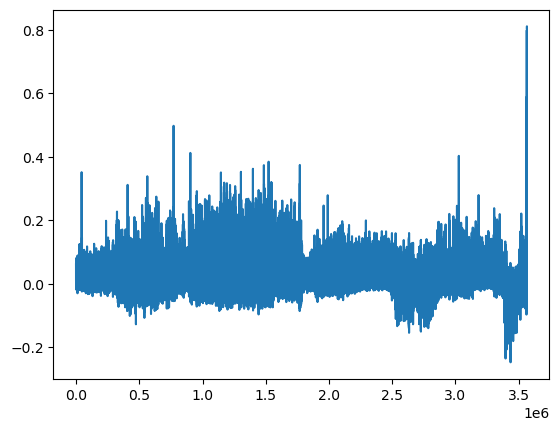

In [7]:
from matplotlib import pyplot as plt


plt.plot(noise_0)

In [8]:
from typing import Tuple
from scipy.fft import fft

def compute_mean(signal):
    """
    Compute the mean of the signal.
    
    Parameters:
    signal (numpy.ndarray): The input signal.
    
    Returns:
    float: The mean of the signal.
    """
    return np.mean(signal)

def compute_autocorrelation(signal):
    """
    Compute the autocorrelation of the signal.
    
    Parameters:
    signal (numpy.ndarray): The input signal.
    
    Returns:
    numpy.ndarray: The autocorrelation of the signal.
    """
import tensorflow as tf

# Assuming signal is your input 1D array
def compute_autocorrelation(signal):
    # Convert the signal to a TensorFlow tensor
    signal = tf.convert_to_tensor(signal, dtype=tf.float32)
    
    # Subtract the mean
    signal_mean = tf.reduce_mean(signal)
    signal = signal - signal_mean
    
    # Pad the signal to the next power of 2 for efficient FFT computation
    signal_length = tf.shape(signal)[0]
    padded_length = tf.cast(2 ** tf.math.ceil(tf.math.log(tf.cast(signal_length, tf.float32)) / tf.math.log(2.0)), tf.int32)
    signal = tf.pad(signal, [[0, padded_length - signal_length]])
    
    # Compute the FFT of the signal
    fft_signal = tf.signal.fft(tf.cast(signal, tf.complex64))
    
    # Compute the power spectrum (fft * conjugate)
    power_spectrum = fft_signal * tf.math.conj(fft_signal)
    
    # Compute the IFFT to get the autocorrelation
    autocorr = tf.signal.ifft(power_spectrum)
    
    # Keep only the real part and normalize
    autocorr = tf.math.real(autocorr) / tf.cast(signal_length, tf.float32)
    
    # Return the autocorrelation for the original signal length
    return autocorr[:signal_length]



def compute_power_spectral_density(signal):
    """
    Compute the power spectral density of the signal.
    
    Parameters:
    signal (numpy.ndarray): The input signal.
    
    Returns:
    numpy.ndarray: The power spectral density of the signal.
    """
    signal_fft = fft(signal)
    psd = np.abs(signal_fft) ** 2 / len(signal)
    return psd

def white_noise_elements(signal, max_mean: float = 1e-10) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Check if the signal is white noise.
    
    Parameters:
    signal (numpy.ndarray): The input signal.
    
    Returns:
    bool: True if the signal is white noise, False otherwise.
    """
    signal_mean = compute_mean(signal)
    has_mean_zero = np.abs(signal_mean) < max_mean
    print("Has zero mean?", has_mean_zero, f"(mean is {signal_mean})")
    psd = compute_power_spectral_density(signal)
    plt.plot(psd)
    plt.show()

    autocorr = compute_autocorrelation(signal)
    n_0 = autocorr[0]
    dirac_like = np.allclose(autocorr[1:], 0.0, atol=max_mean)
    print("Dirac-like?", dirac_like)

    constant_psd = np.allclose(n_0, psd, atol=max_mean)
    print("Constant PSD?", constant_psd)
    return signal_mean, autocorr, psd

Has zero mean? False (mean is 0.016953240105099784)


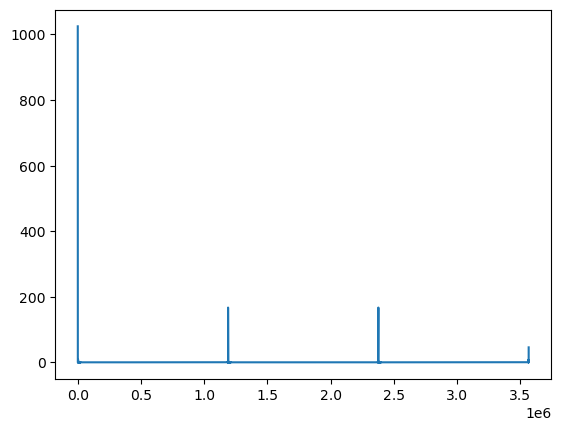

Dirac-like? False
Constant PSD? False


In [9]:
mean, autocorr, psd = white_noise_elements(noise_0)

In [10]:
psd.shape

(3564993,)

In [12]:
autocorr.shape

TensorShape([3564993])

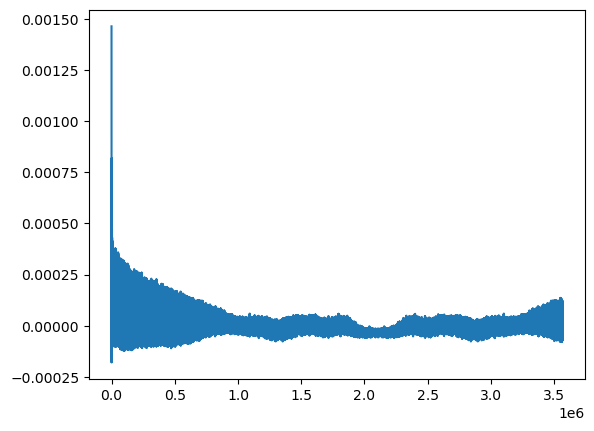

In [ ]:
plt.plot(autocorr)